# Analysis combined of different algorithms

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# load numpy arrays from files
devrl_returns = np.load('DevRL/BG_NOISE/overall_returns.npy')
devrl_params = np.load('DevRL/BG_NOISE/parameter_values.npy')

dual_pathway_returns = np.load('Dual_pathway/BG_NOISE/overall_returns.npy')
dual_pathway_params = np.load('Dual_pathway/BG_NOISE/parameter_values.npy') 

stdrl_returns = np.load('std_RL/BG_NOISE/overall_returns.npy')
stdrl_params = np.load('std_RL/BG_NOISE/parameter_values.npy')

simannealing_returns = np.load('Sim_Annealing/NOISE/overall_returns.npy')
simannealing_params = np.load('Sim_Annealing/NOISE/parameter_values.npy')


In [9]:
def plot_results(returns, params, label):
    returns = np.array(returns) * 100
    sorted_params = sorted(params)
    # print(sorted_params)    
    sorted_indices = np.argsort(params)

    returns = returns[:,sorted_indices]
    above_threshold = np.zeros(len(params))
    for i in range(len(params)):
        above_threshold[i] = np.sum(returns[:,i] > 70)
    plt.bar(range(len(params)), 100*above_threshold/len(returns), color='blue', alpha=0.5)
    for i in range(len(params)):
        plt.plot(i * np.ones_like(returns[:,i]), returns[:,i], 'o', color='black', markersize=0.5, alpha = 0.2)
        plt.text(i, 100*above_threshold[i]/len(returns), f"{100*above_threshold[i]/len(returns):.1f}%", ha='center', va='bottom')
    plt.xlabel('Parameter set')        
    plt.hlines(70, 0, len(params), colors='r', linestyles='dashed')
    plt.xticks(np.arange(len(params), step=1), labels=sorted_params)
    plt.ylabel('Percentage of runs above 70%')  
    plt.ylim(0, 100)
    plt.title(f"Variability of performance for {label} with noise") 
    plt.legend()    
    plt.show()  






/tmp/ipykernel_2206666/2865661162.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


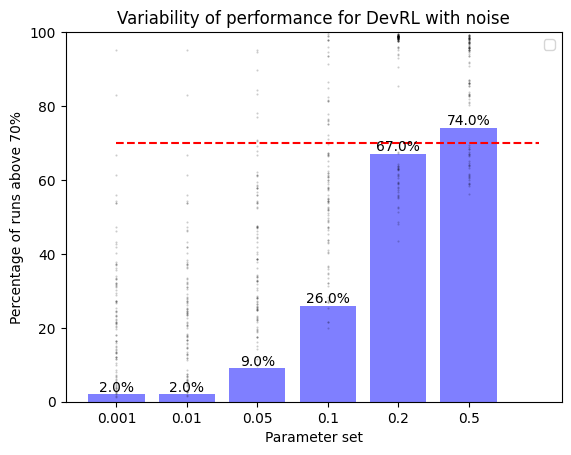

/tmp/ipykernel_2206666/2865661162.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


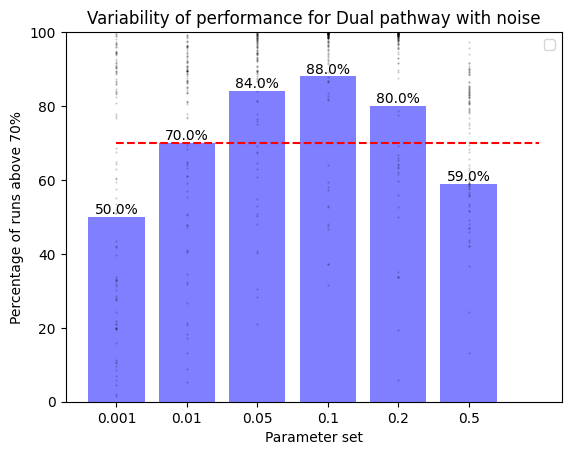

/tmp/ipykernel_2206666/2865661162.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


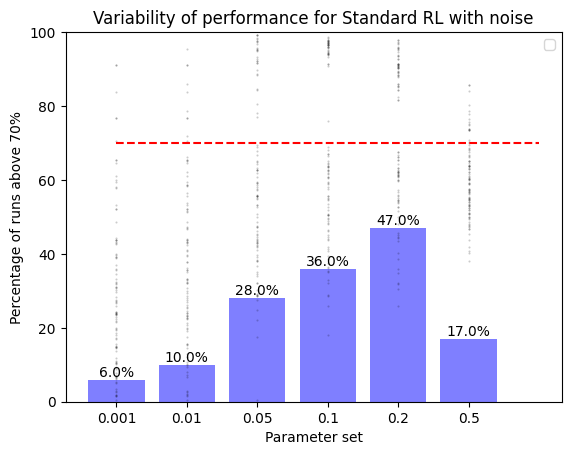

/tmp/ipykernel_2206666/2865661162.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


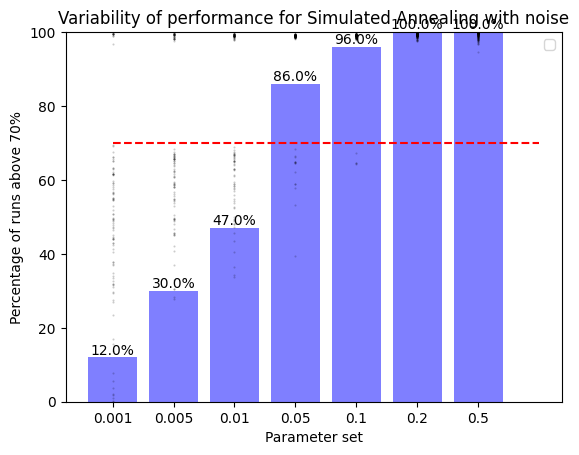

In [10]:
plot_results(devrl_returns, devrl_params, 'DevRL')  
plot_results(dual_pathway_returns, dual_pathway_params, 'Dual pathway')
plot_results(stdrl_returns, stdrl_params, 'Standard RL')
plot_results(simannealing_returns, simannealing_params, 'Simulated Annealing')    